# Generate text from EXIF metadata

In [1]:
from PIL import Image, ExifTags
from PIL.ExifTags import TAGS, GPSTAGS
import datetime

In [2]:
def get_exif_data(image):
    """Returns a dictionary from the exif data of an PIL Image item. Also converts the GPS Tags"""
    exif_data = {}
    info = image._getexif()
    if info:
        for tag, value in info.items():
            decoded = TAGS.get(tag, tag)
            if decoded == "GPSInfo":
                gps_data = {}
                for t in value:
                    sub_decoded = GPSTAGS.get(t, t)
                    gps_data[sub_decoded] = value[t]

                exif_data[decoded] = gps_data
            else:
                exif_data[decoded] = value

    return exif_data

In [3]:
def _get_if_exist(data, key):
    if key in data:
        return data[key]
    return None

In [4]:
def _convert_to_degress(value):
    """Helper function to convert the GPS coordinates stored in the EXIF to degress in float format"""
    d0 = value[0][0]
    d1 = value[0][1]
    d = float(d0) / float(d1)

    m0 = value[1][0]
    m1 = value[1][1]
    m = float(m0) / float(m1)

    s0 = value[2][0]
    s1 = value[2][1]
    s = float(s0) / float(s1)

    return d + (m / 60.0) + (s / 3600.0)

In [5]:
def get_lat_lon(exif_data):
    """Returns the latitude and longitude, if available, from the provided exif_data (obtained through get_exif_data above)"""
    lat = None
    lon = None

    if "GPSInfo" in exif_data:		
        gps_info = exif_data["GPSInfo"]

        gps_latitude = _get_if_exist(gps_info, "GPSLatitude")
        gps_latitude_ref = _get_if_exist(gps_info, 'GPSLatitudeRef')
        gps_longitude = _get_if_exist(gps_info, 'GPSLongitude')
        gps_longitude_ref = _get_if_exist(gps_info, 'GPSLongitudeRef')

        if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
            lat = _convert_to_degress(gps_latitude)
            if gps_latitude_ref != "N":                     
                lat = 0 - lat

            lon = _convert_to_degress(gps_longitude)
            if gps_longitude_ref != "E":
                lon = 0 - lon

    return lat, lon

In [6]:
def generate_watermark_text(img_path):
    img = Image.open(img_path)
    exif = get_exif_data(img)
    if "MakerNote" in exif:
        del exif["MakerNote"]
    if get_lat_lon(exif)[0] is not None:
        exif["GPSLocation"] = round(get_lat_lon(exif)[0],6) , round(get_lat_lon(exif)[1],6)
        exif["GPSHPositioningError"] = round(exif["GPSInfo"]["GPSHPositioningError"][0]/exif["GPSInfo"]["GPSHPositioningError"][1])
        exif["GoogleMapURL"] = "https://maps.google.com/?q={},{}".format(exif["GPSLocation"][0],exif["GPSLocation"][1])
    else:
        print("Not found GPS Location.")
    created_date = datetime.datetime.strptime(exif["DateTimeOriginal"],"%Y:%m:%d %H:%M:%S")
    iso = exif["ISOSpeedRatings"]
    focal_length = exif["FocalLength"][0]/exif["FocalLength"][1]
    model = exif["Model"]
#     model = model.replace(" ","")
    aperture = exif["FNumber"][0]/exif["FNumber"][1]
    shutter_speed = str(exif["ExposureTime"][0])+"/"+str(exif["ExposureTime"][1])
    if get_lat_lon(exif)[0] is not None:
        gps_location = str(exif["GPSLocation"][0]) + ", " + str(exif["GPSLocation"][1])
        gps_h_position_error = exif["GPSHPositioningError"]
    
    
    result = ""
    result += "{}".format(created_date.strftime('%d %b %Y %H:%M'))
    result += "\n{}, ISO {} {}mm F{} {}".format(model, iso, focal_length,aperture,shutter_speed)
    if get_lat_lon(exif)[0] is not None and gps_h_position_error < 50:
        result += "\n{}".format(gps_location,gps_h_position_error)
    return result, exif

In [7]:
print(generate_watermark_text('test_img.jpeg')[0])

01 Feb 2019 18:38
iPhone XS, ISO 500 6.0mm F2.4 1/33
19.359439, 98.442581


# Create Google Map QR Code

In [8]:
import qrcode

In [9]:
def create_qr_code(url, box_size=7, border=2):
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=box_size,
        border=border,
    )
    qr.add_data(url)
    qr.make(fit=True)

    img = qr.make_image(fill_color="black", back_color="white")
    return img

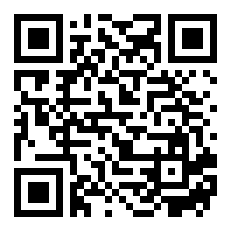

In [10]:
qr_code_img = create_qr_code("https://maps.google.com/?q=19.359439,98.442581")
qr_code_img

# Generate watermark on target image

In [11]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from pathlib import Path

In [12]:
def generate_water_mark_using_exif(original_image_path, font, offset = 25, spacing = 5, align_vertical = "top", align_horizontal = "left", qr_box_size = 10, qr_border = 2):
    img = Image.open(original_image_path)
    lines, exif = generate_watermark_text(in_img_path)
    lines = lines.split("\n")
    if "GPSLocation" in exif:
        qr_code_img = create_qr_code(exif["GoogleMapURL"] , qr_box_size, qr_border)
        qr_w, qr_h = qr_code_img.size
    else:
        qr_w = 0,
        qr_h = 0

    W, H = img.size
    canvas = ImageDraw.Draw(img)

    # set initial y-pos
    if align_vertical == "top":
        y_pos = offset
    else:
        y_pos = H - offset * 2 - qr_h - spacing
        lines = list(reversed(lines))

    # Draw each line
    for line in lines:
        w, h = font.getsize(line)
        if align_horizontal == "right":
            x_pos =  W - w - offset
        else:
            x_pos =  offset

        # update y_pos
        if align_vertical == "bot":
            y_pos -= (spacing + h)

        canvas.text((x_pos, y_pos), line, font=font, fill="white")

        # update y_pos
        if align_vertical == "top":
            y_pos += spacing + h

    # Draw QR Code
    if "GPSLocation" in exif:
        if align_horizontal == "right":
            x_pos =  W - qr_w - offset
        else:
            x_pos =  offset
        if align_vertical == "bot":
            y_pos = H - qr_h - offset
        else: 
            y_pos += offset
        img.paste(qr_code_img, (x_pos, y_pos))
    return img

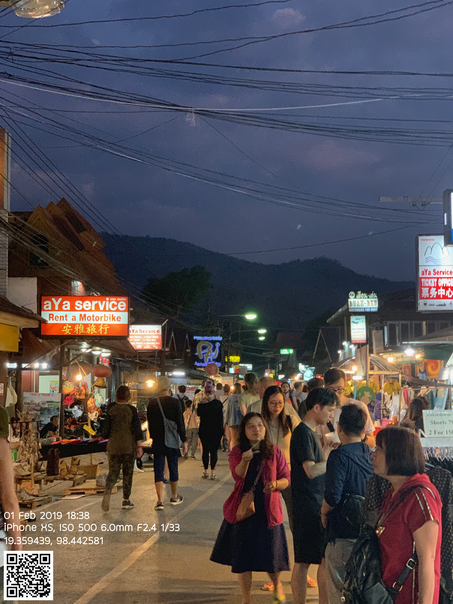

In [13]:
in_img_path = 'test_img.jpeg'
out_img_path = str(Path(in_img_path).stem) +"_watermarked" + (Path(in_img_path).suffix)

font = ImageFont.truetype("FC Lamoon Regular ver 1.00.ttf", 100)
out_img = generate_water_mark_using_exif(in_img_path, font, align_vertical = "bot", align_horizontal = "left")
out_img.save(out_img_path)

W,H = out_img.size
out_img = out_img.resize((int(W*0.15),int(H*0.15)), Image.ANTIALIAS)
out_img

# Clone original EXIF data

In [14]:
import piexif

In [15]:
def clone_exif_data(original_img_path, target_img_path):
    piexif.transplant(original_img_path, target_img_path)

In [16]:
clone_exif_data(in_img_path, out_img_path)

# Process Whole Target Folder

In [17]:
import os
from pathlib import Path

In [18]:
in_folder_path = "test_folder"
out_folder_path = "out_test_folder"
if not os.path.exists(out_folder_path):
    os.makedirs(out_folder_path)
for file in os.listdir(in_folder_path):
    in_img_path = Path(in_folder_path+"/"+file)
    out_img_file = str(Path(in_img_path).stem) +"_watermarked" + (Path(in_img_path).suffix)
    out_img_path = Path(out_folder_path + "/" + out_img_file)

    font = ImageFont.truetype("FC Lamoon Regular ver 1.00.ttf", 100)
    out_img = generate_water_mark_using_exif(in_img_path, font, align_vertical = "bot", align_horizontal = "left")
    out_img.save(out_img_path)
    print("Processed [{}]".format(file))

Processed [test_img.jpeg]
